In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg') # do not show plot without plt.show.
import PBMethods as PM
import time
import glob

from IPython.display import clear_output
import imageio 

def makeGif(iPath, oPath, num):
    with imageio.get_writer(oPath, mode='I') as writer:
        for i in range(num):
            name = iPath + "/" + str(i) + ".png"
            image = imageio.imread(name)
            writer.append_data(image)

In [2]:
# OLD WORKING CELL

# setup_edgs with overlapping allowed. 
def rough_edges(center_x, center_y, r):
    edges = np.zeros((len(center_x), len(center_x)))

    # If ball n and ball m are touching, edges(n, m) = 1 only when n < m, else edges(n, m) = 0.
    # diagonal entries are automatically 0, as a ball is not allowed to collide with itself.
    for i in range(len(center_x)):
        for j in range(i, len(center_x)):
            x_i = np.array([center_x[i], center_y[i]])
            x_j = np.array([center_x[j], center_y[j]])
            if i != j:
                # allow an error of 1e-15 to accomodate for numerical error
#                 If overlap, denote as -1
                if np.linalg.norm(x_i-x_j) < (2*r - 1e-15):
                    edges[i, j] = -1
#                 If no overlap but touch, denote as 1
                elif np.linalg.norm(x_i-x_j) < (2*r + 1e-15):
                    edges[i, j] = 1
                    
                
    return edges
    
def pairwise_collidable(i, j, center_x, center_y, v_x, v_y, r):
#     find x coord for intersection of trajectory

# check when both balls have vertical trajectory
    x = 0
    x_s = 0
    x_e = 0
    t_s = 0
    t_e = 0
    moving_ball = 0
    target_ball = 0
    
    if v_x[i] == 0 and v_x[j] == 0:
#         both vertical, no collision. 
        if abs(center_x[i] - center_x[j]) > 2*r:
#             no collision: too far
            return False
        else:
#             giving in suitable distance
#             lower ball move up, higher ball move down faster, or two ball move toward each other. Can collied. Otherwise no collide
            return (v_y[i] - v_y[j])*(center_y[i] - center_y[j]) < 0
# if only one ball have vertical trajectory, collision will happen and must happen at that x value,
    elif v_x[i] == 0:
        s_j = v_y[j]/v_x[j]
        if v_y[i] == 0:
            distance = np.abs(-s_j*center_x[i]+center_y[i]-center_y[j]+s_j*center_x[j])/np.sqrt(s_j**2+1)
            return distance < 2*r
        x = center_x[i]
        x_s = x - np.sign(v_x[j])*np.sqrt(((2*r)**2)/(s_j**2+1))
        x_e = x + np.sign(v_x[j])*np.sqrt(((2*r)**2)/(s_j**2+1))
        t_s = (x_s-center_x[j])/v_x[j]
        t_e = (x_e-center_x[j])/v_x[j]
        moving_ball = i
        target_ball = j
        y_offset = np.sqrt(1/(1+1/s_j**2))
    
    elif v_x[j] == 0:
        s_i = v_y[i]/v_x[i]
        if v_y[j] == 0:
            distance = np.abs(-s_i*center_x[j]+center_y[j]-center_y[i]+s_i*center_x[i])/np.sqrt(s_i**2+1)
            return distance < 2*r
        x = center_x[j]
        x_s = x - np.sign(v_x[i])*np.sqrt(((2*r)**2)/(s_i**2+1))
        x_e = x + np.sign(v_x[i])*np.sqrt(((2*r)**2)/(s_i**2+1))
        t_s = (x_s-center_x[i])/v_x[i]
        t_e = (x_e-center_x[i])/v_x[i]
        moving_ball = j
        target_ball = i
        y_offset = np.sqrt(1/(1+1/s_i**2))
    
    else:
#         in this case, none have vertical trajectory, safe to compute slope
        s_i = v_y[i]/v_x[i]
        s_j = v_y[j]/v_x[j]
        
        if s_i == s_j:
#             if the two trajectories are parallel, check distance between line and direction of movement
#             much like in the first case. 

#             distance between the two trajectories
            d = abs(center_y[i] - center_y[j]) / ((s_i**2) + 1);
            if abs(d) > 2*r:
                return False
            else:
#             giving in suitable distance, test x velocity indicates the direction and speed the ball is moving at relatively to eachother.
                return (v_x[i] - v_x[j])*(center_x[i] - center_x[j]) < 0

#         if the two balls are not parallel, at least one have non-zero slope. 
        else:
            if s_i != 0:
#             two ball not parallel, not vertical. Find x value for intersection. 
                x = (s_j*(x-center_x[j]) + center_y[j]-center_y[i])/s_i+center_x[i]
    
            else:
#             two ball not parallel, not vertical. Find x value for intersection. 
                x = (s_i*(x-center_x[i]) + center_y[i]-center_y[j])/s_j+center_x[j]
            x_s = x - np.sign(v_x[i])*np.sqrt(((2*r)**2)/(s_i**2+1))
            x_e = x + np.sign(v_x[i])*np.sqrt(((2*r)**2)/(s_i**2+1))
            t_s = (x_s-center_x[i])/v_x[i]
            t_e = (x_e-center_x[i])/v_x[i]
            moving_ball = j
            target_ball = i
            y_offset = np.sqrt(((2*r)**2)/(1+1/s_i**2))

            
    return hit_tester(t_s, t_e, moving_ball, target_ball, y_offset, center_x, center_y, v_x, v_y, r)

def collidable(center_x, center_y, v_x, v_y, r):
    for i in range(len(center_x)):
        for j in range(i+1, len(center_x)):
            if pairwise_collidable(i, j, center_x, center_y, v_x, v_y, r):
                return True
            
    return False

def check_collision(i, j, edges, center_x, center_y, v_x, v_y):
    if edges[i, j] == 0:
        return 0
    else:
        x_i = np.array([center_x[i], center_y[i]])
        x_j = np.array([center_x[j], center_y[j]])
        v_i = np.array([v_x[i], v_y[i]])
        v_j = np.array([v_x[j], v_y[j]])
        
        if np.dot(v_i-v_j, x_i-x_j) >= 0:
            return 0
        else:
            return 1

def all_collision(edges, center_x, center_y, v_x, v_y, r):
    contact = np.where(edges == 1)
    overlap = np.where(edges == -1)
    contactcollide = []
    overlapcollide = []
    for i in range(len(contact[0])):
        if check_collision(contact[0][i], contact[1][i], edges, center_x, center_y, v_x, v_y) == 1:
            contactcollide.append([contact[0][i], contact[1][i]])
            
    for i in range(len(overlap[0])):
        if check_collision(overlap[0][i], overlap[1][i], edges, center_x, center_y, v_x, v_y) == 1:
            overlapcollide.append([overlap[0][i], overlap[1][i]])
            
    return contactcollide, overlapcollide

def moving_ball_model(center_x, center_y, v_x, v_y, r, steps, resolution, location = "", save = False):
#     default to not save. Default save location is current directory.
    
    xs = [center_x]
    ys = [center_y]

    this_x = np.copy(v_x).astype('float64')
    this_y = np.copy(v_y).astype('float64')
    v_xs = [this_x]
    v_ys = [this_y]

    step = 0
    collide_count = 0
    while step < steps:
    #     collide
        edges = rough_edges(center_x, center_y, r)
        contactcollide, overlapcollide = all_collision(edges, center_x, center_y, this_x, this_y, r)
#         print(edges)
#         print("touch collide: ", contactcollide)
#         print("overlap collide: ", overlapcollide)
        
        if len(overlapcollide) > 0:
#             In this case, overlap exists. Perform an overlapping collision.
#             We first get the list of overlapping 
            rand = random.randint(0, len(overlapcollide)-1)
            collide_count += 1
            i = overlapcollide[rand][0]
            j = overlapcollide[rand][1]
            this_x, this_y = PM.perform_collision(i, j, edges, center_x, center_y, this_x, this_y)

        elif len(contactcollide) > 0:
#             In this case, overlap does not exist, yet further collision may happen. Perform a random collision
            rand = random.randint(0, len(contactcollide)-1)
            collide_count += 1
            i = contactcollide[rand][0]
            j = contactcollide[rand][1]
            this_x, this_y = PM.perform_collision(i, j, edges, center_x, center_y, this_x, this_y)

    #     move
        v_xs.append(this_x)
        v_ys.append(this_y)
        step += 1
        center_x = this_x*resolution + center_x
        center_y = this_y*resolution + center_y
        xs.append(center_x)
        ys.append(center_y)
        
    if save:
        fig, ax = plt.subplots(1, 1, figsize = (20, 20))
        for i in range(step):
            PM.visualize(xs[i], ys[i], v_xs[i], v_ys[i], r, ax)
            plt.savefig(location + "/" + str(i) + ".png")
            plt.cla()

    return collide_count, v_xs, v_ys

def forward_to_collision(center_x, center_y, v_x, v_y, r):
    if not collidable(center_x, center_y, v_x, v_y, r):
        print("System cannot collide.")
        return 0
    else:
        itr = 0
        edges = rough_edges(center_x, center_y, r)
        while len(PM.all_collision(edges, center_x, center_y, v_x, v_y, r)) == 0:
            itr = itr+1
            center_x = v_x*0.05 + center_x
            center_y = v_y*0.05 + center_y
            edges = rough_edges(center_x, center_y, r)
        return center_x, center_y

Ball with initial velocity:  8
IV:  [0.99689649 0.07872344]
Total number of collisions when considered as a moving ball model: 29
Moving model executed 100 time steps, taking 17.172574281692505 seconds.
Total number of collisions when considered as a fixed ball model: 30
Fixed model taking 5.2267186641693115 seconds.


<ipython-input-1-04dade579076>:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(name)


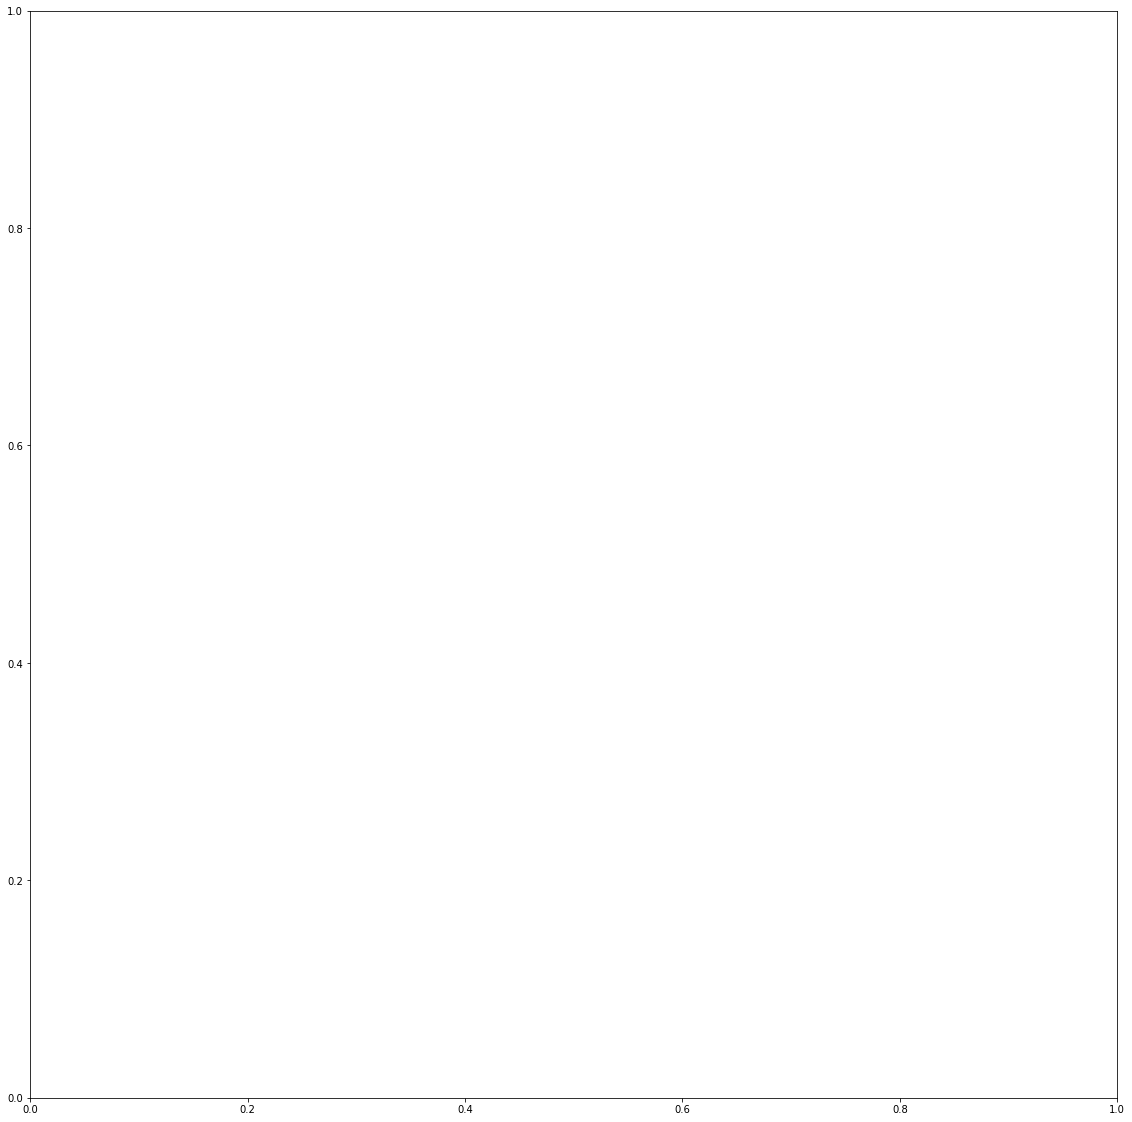

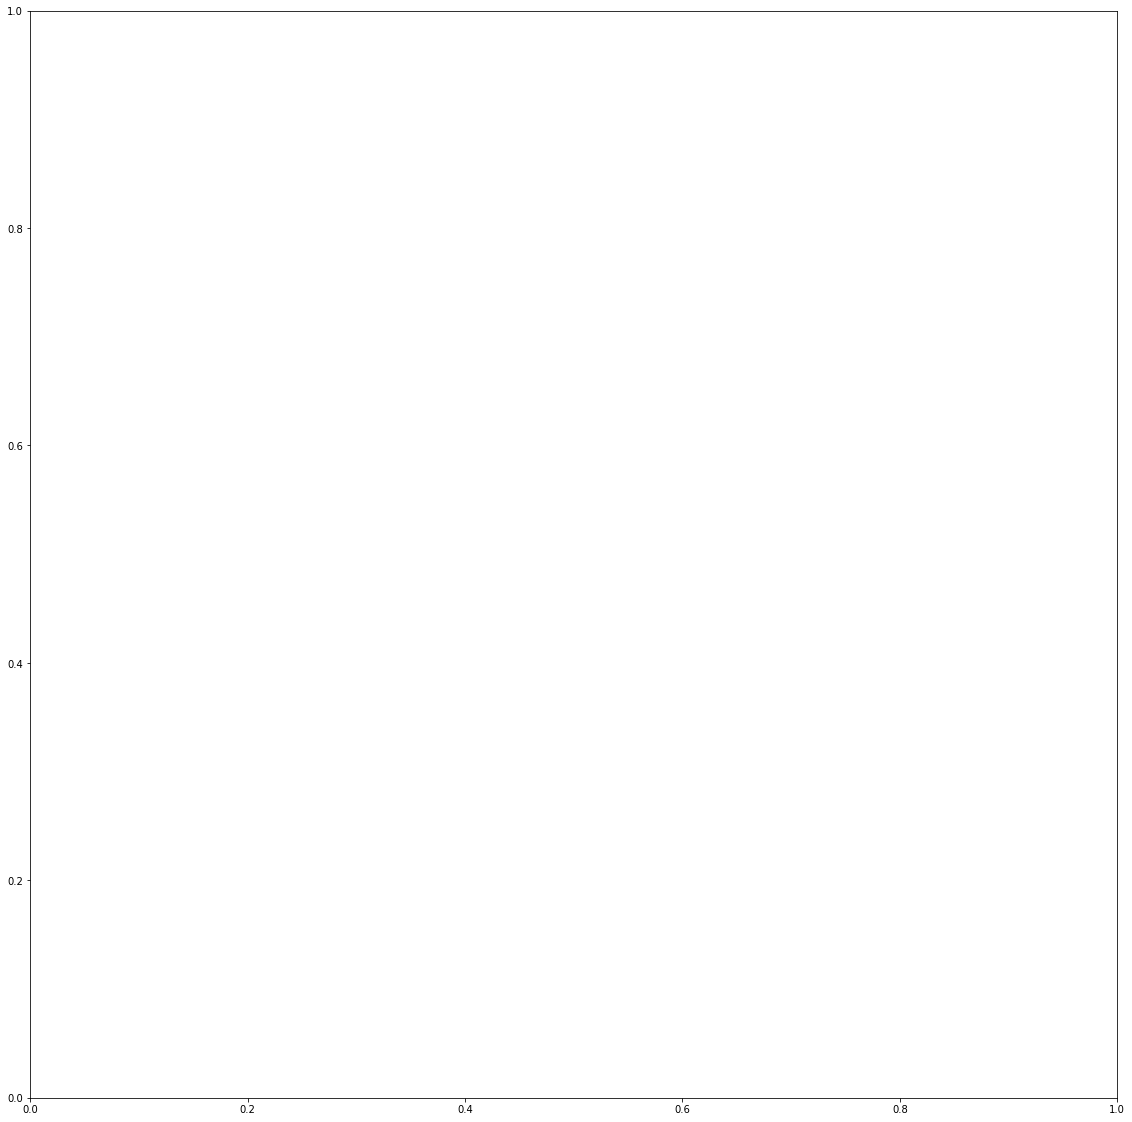

In [3]:
r = 1
resolution = 0.05
center_x = np.array([3, 2, 4, 1, 3, 5 ,0, 2, 4, 6, 3, 2, 4, 1, 3, 5])
center_y = np.array([3*np.sqrt(3), 2*np.sqrt(3), 2*np.sqrt(3), np.sqrt(3), np.sqrt(3), np.sqrt(3), 0, 0, 0, 0, -3*np.sqrt(3), -2*np.sqrt(3), -2*np.sqrt(3), -np.sqrt(3), -np.sqrt(3), -np.sqrt(3)])
v_x = np.zeros(16)
v_y = np.zeros(16)
    
#     randomly choose an interior ball to have initial velocity
interior = [4, 7, 8, 14]
iv = random.randint(0, len(interior)-1)
v = [np.random.rand(), np.random.rand()]
v_norm = v / np.linalg.norm(v)
v_x[interior[iv]] = v_norm[0]
v_y[interior[iv]] = v_norm[1]

print("Ball with initial velocity: ", interior[iv])
print("IV: ", v_norm)
steps = 100

s = time.time()
step, _, _ = moving_ball_model(center_x, center_y, v_x, v_y, r, steps, resolution, "Plots/MovingModel", True)
t = time.time()-s
print('Total number of collisions when considered as a moving ball model:', step)
print("Moving model executed", steps, "time steps, taking", t, "seconds.")

s1 = time.time()
edges = rough_edges(center_x, center_y, r)
step = PM.pinned_random_model(edges, center_x, center_y, v_x, v_y, r, "Plots/FixedModel", True)
t1 = time.time()-s1
print("Total number of collisions when considered as a fixed ball model:", step)
print("Fixed model taking", t1, "seconds.")

# Make a GIF for visualization
makeGif("Plots/MovingModel", "moving_example.gif", steps)
makeGif("Plots/FixedModel", "pinned_example.gif", step)

In [ ]:
r = 1
resolution = 0.05
center_x = np.array([3, 2, 4, 1, 3, 5 ,0, 2, 4, 6, 3, 2, 4, 1, 3, 5])
center_y = np.array([3*np.sqrt(3), 2*np.sqrt(3), 2*np.sqrt(3), np.sqrt(3), np.sqrt(3), np.sqrt(3), 0, 0, 0, 0, -3*np.sqrt(3), -2*np.sqrt(3), -2*np.sqrt(3), -np.sqrt(3), -np.sqrt(3), -np.sqrt(3)])
v_x = np.zeros(16)
v_y = np.zeros(16)
    
#     randomly choose an interior ball to have initial velocity
interior = [4, 7, 8, 14]
iv = random.randint(0, len(interior)-1)
v = [np.random.rand(), np.random.rand()]
v_norm = v / np.linalg.norm(v)
v_x[interior[iv]] = v_norm[0]
v_y[interior[iv]] = v_norm[1]

print("Ball with initial velocity: ", interior[iv])
print("IV: ", v_norm)
    
sample_size = 1000
moving = np.zeros(sample_size).astype("int32")
moving_vxs = []
moving_vys = []
steps = 100

s = time.time()
for i in range(sample_size):
    moving[i], vx, vy = moving_ball_model(center_x, center_y, v_x, v_y, r, steps, resolution, "Plots/MovingModel/1")
    moving_vxs.append(vx[-1])
    moving_vys.append(vy[-1])
t = time.time() - s

print("Obtained", sample_size, "moving samples, taking", t, "seconds.")

Ball with initial velocity:  7
IV:  [0.97005578 0.24288223]


In [ ]:
r = 1
center_x = np.array([3, 2, 4, 1, 3, 5 ,0, 2, 4, 6, 3, 2, 4, 1, 3, 5])
center_y = np.array([3*np.sqrt(3), 2*np.sqrt(3), 2*np.sqrt(3), np.sqrt(3), np.sqrt(3), np.sqrt(3), 0, 0, 0, 0, -3*np.sqrt(3), -2*np.sqrt(3), -2*np.sqrt(3), -np.sqrt(3), -np.sqrt(3), -np.sqrt(3)])
v_x = np.zeros(16)
v_y = np.zeros(16)
    
#     randomly choose an interior ball to have initial velocity
v_x[interior[iv]] = v_norm[0]
v_y[interior[iv]] = v_norm[1]

print("Ball with initial velocity: ", interior[iv])
print("IV: ", v_norm)
    
sample_size = 1000
pinned = np.zeros(sample_size).astype("int32")
pinned_vxs = []
pinned_vys = []

edges = rough_edges(center_x, center_y, r)

s = time.time()
for i in range(sample_size):
    num_collide, vx, vy = PM.random_run(center_x, center_y, v_x, v_y, r, edges)
    pinned[i] = len(num_collide)-1
    pinned_vxs.append(vx[-1])
    pinned_vys.append(vy[-1])
t = time.time() - s

print("Obtained", sample_size, "pinned samples, taking", t, "seconds.")

In [ ]:
data = np.zeros((sample_size, 2))
data[:, 0] = pinned
data[:, 1] = moving

In [ ]:
df = pd.DataFrame(data, columns = ["pinned", "moving"])
df.describe()

In [ ]:
df.plot.hist(x = "pinned")

In [ ]:
df.plot.hist(x = "moving")